In [1]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np
import seaborn as sns

from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.stattools import adfuller

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.api import OLS
import matplotlib.pyplot as plt

In [2]:
SBSP_df = pd.read_excel('SBSP3.xlsx', sheet_name= "normal")
SBSP_df['Data'] = pd.to_datetime(SBSP_df['Data'])
SBSP_df['SBSP_diff'] = SBSP_df['SBSP'].diff()
SBSP_df = SBSP_df.dropna()
SBSP_df

,Data,SBSP,LN_SBSP,LN_DIFF_SBSP,SBSP_diff
1,2011-02-28,9.928898,2.295449,-0.000739,-0.007340
2,2011-03-31,11.446117,2.437651,0.142201,1.517219
3,2011-04-29,11.978629,2.483124,0.045474,0.532512
4,2011-05-31,11.762765,2.464939,-0.018185,-0.215864
5,2011-06-30,11.319479,2.426525,-0.038414,-0.443286
...,...,...,...,...,...
154,2023-11-30,67.560000,4.213016,0.146214,9.190000
155,2023-12-28,75.370000,4.322409,0.109393,7.810000
156,2024-01-31,78.860000,4.367674,0.045265,3.490000
157,2024-02-29,79.160000,4.371471,0.003797,0.300000


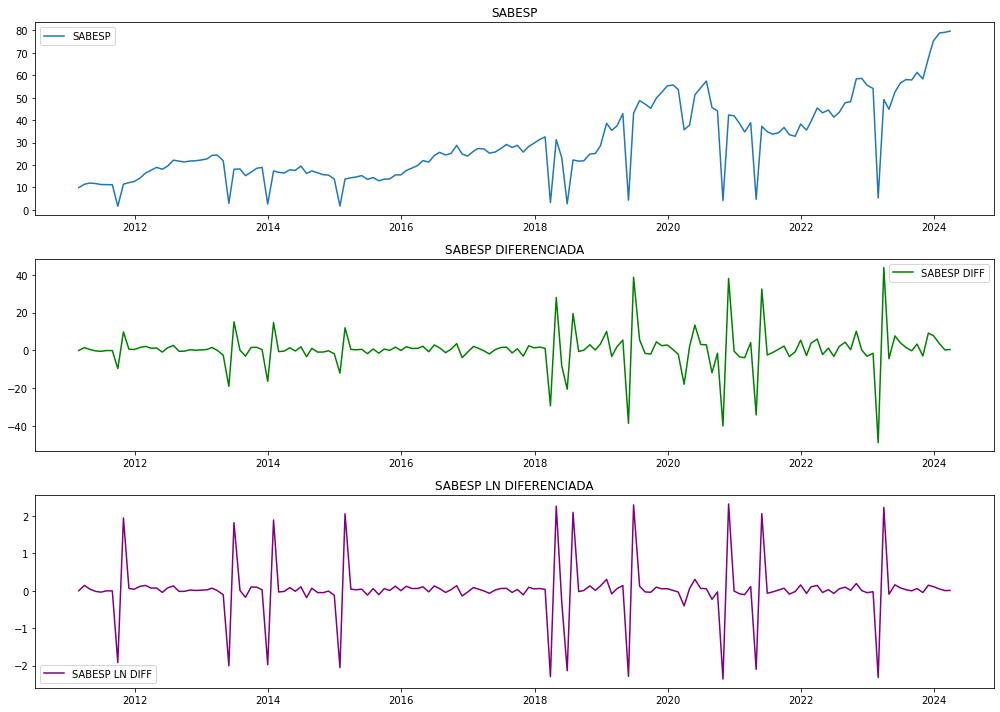

In [3]:
plt.figure(figsize=(14, 10))

plt.subplot(3, 1, 1)
plt.plot(SBSP_df['Data'] , SBSP_df['SBSP'], label='SABESP')
plt.title('SABESP')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(SBSP_df['Data'] ,SBSP_df['SBSP_diff'], label='SABESP DIFF', color='green')
plt.title('SABESP DIFERENCIADA')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(SBSP_df['Data'] ,SBSP_df['LN_DIFF_SBSP'], label='SABESP LN DIFF', color='purple')
plt.title('SABESP LN DIFERENCIADA')
plt.legend()

plt.tight_layout()
plt.show()

In [5]:
# Function to perform the ADF test
def adf_test(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
# Apply the ADF test on each series
print("SBSP:")
adf_test(SBSP_df['SBSP'])

print("\nSBSP DIFF:")
adf_test(SBSP_df['SBSP_diff'])

# print("\nSBSP LN:")
# adf_test(SBSP_df['LN_SBSP'])

print("\nSBSP LN DIFF:")
adf_test(SBSP_df['LN_DIFF_SBSP'])

SBSP:
Results of Dickey-Fuller Test:
Test Statistic                   0.541127
p-value                          0.986071
#Lags Used                       5.000000
Number of Observations Used    152.000000
Critical Value (1%)             -3.474121
Critical Value (5%)             -2.880750
Critical Value (10%)            -2.577013
dtype: float64

SBSP DIFF:
Results of Dickey-Fuller Test:
Test Statistic                -9.453868e+00
p-value                        4.539860e-16
#Lags Used                     4.000000e+00
Number of Observations Used    1.530000e+02
Critical Value (1%)           -3.473830e+00
Critical Value (5%)           -2.880623e+00
Critical Value (10%)          -2.576945e+00
dtype: float64

SBSP LN DIFF:
Results of Dickey-Fuller Test:
Test Statistic                -8.568288e+00
p-value                        8.330495e-14
#Lags Used                     5.000000e+00
Number of Observations Used    1.520000e+02
Critical Value (1%)           -3.474121e+00
Critical Value (5%)   

In [54]:
print(SBSP_df.info())
print(SBSP_df.describe())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 158 entries, 1 to 158
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Data          158 non-null    datetime64[ns]
 1   SBSP          158 non-null    float64       
 2   LN_SBSP       158 non-null    float64       
 3   LN_DIFF_SBSP  158 non-null    float64       
 4   SBSP_diff     158 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 7.4 KB
None
             SBSP     LN_SBSP  LN_DIFF_SBSP   SBSP_diff
count  158.000000  158.000000    158.000000  158.000000
mean    29.476609    3.172828      0.013175    0.441353
std     17.215335    0.734543      0.764580   10.791047
min      1.642454    0.496191     -2.360832  -48.805371
25%     16.573971    2.807813     -0.039641   -1.150611
50%     25.053766    3.221018      0.023398    0.506645
75%     41.791538    3.732676      0.084973    2.154419
max     79.670000    4.377893     

Pelo teste de estacionariedade de dickey fuller aumentado, a série é estacionária diferenciada e logaritmizada e diferenciada.

Vamos importar os indicadores e iniciar a análise exploratória.

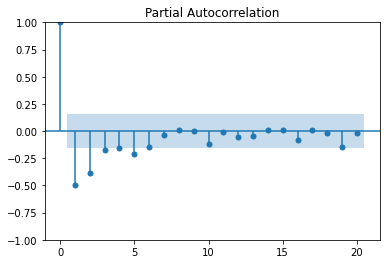

In [199]:
#PACF
ploct =plot_pacf(SBSP_df['LN_DIFF_SBSP'], lags=20, alpha=0.05) # 3 defasagens


In [56]:
indicadores = pd.read_excel('indicadores.xlsx', sheet_name= "normal")
indicadores['Data'] = pd.to_datetime(indicadores['Data'])
indicadores
indicadores['CAMBIO_diff'] = indicadores['CAMBIO'].diff()
indicadores['IBC-BR_diff'] = indicadores['IBC-BR'].diff()

#criando um dataframe com as variáveis que serão utilizadas
new_df = indicadores.loc[:, ['Data','IPCA', 'CAMBIO_diff', 'IBC-BR_diff', 'CDI', 'SELIC' , 'IGP-M', 'DUMMY']]
new_df = new_df.dropna()
#new_df

#juntando um new_df com o  SBSP_df
df = pd.merge(SBSP_df, new_df, on='Data')
df

,Data,SBSP,LN_SBSP,LN_DIFF_SBSP,SBSP_diff,IPCA,CAMBIO_diff,IBC-BR_diff,CDI,SELIC,IGP-M,DUMMY
0,2011-02-28,9.928898,2.295449,-0.000739,-0.007340,0.80,0.00,3.52,0.842429,0.843905,1.00,0
1,2011-03-31,11.446117,2.437651,0.142201,1.517219,0.79,-0.01,8.75,0.918851,0.920465,0.62,0
2,2011-04-29,11.978629,2.483124,0.045474,0.532512,0.77,-0.07,-5.04,0.838800,0.840161,0.45,0
3,2011-05-31,11.762765,2.464939,-0.018185,-0.215864,0.47,0.02,3.34,0.985266,0.987988,0.43,0
4,2011-06-30,11.319479,2.426525,-0.038414,-0.443286,0.15,-0.02,-1.48,0.952666,0.956276,-0.18,0
...,...,...,...,...,...,...,...,...,...,...,...,...
153,2023-11-30,67.560000,4.213016,0.146214,9.190000,0.28,-0.16,-0.74,0.915991,0.915991,0.59,0
154,2023-12-28,75.370000,4.322409,0.109393,7.810000,0.56,0.00,-0.23,0.894529,0.894529,0.74,0
155,2024-01-31,78.860000,4.367674,0.045265,3.490000,0.42,0.01,-3.59,0.966696,0.966696,0.07,0
156,2024-02-29,79.160000,4.371471,0.003797,0.300000,0.83,0.05,3.97,0.800208,0.800208,-0.52,0


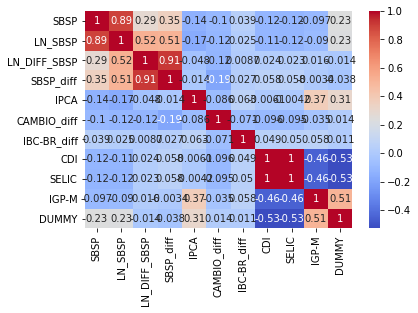

In [57]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [96]:
corr_matrix

,SBSP,LN_SBSP,LN_DIFF_SBSP,SBSP_diff,IPCA,CAMBIO_diff,IBC-BR_diff,CDI,SELIC,IGP-M,DUMMY
SBSP,1.000000,0.892430,0.285264,0.350586,-0.135309,-0.101060,0.038584,-0.116821,-0.122703,-0.096593,0.229678
LN_SBSP,0.892430,1.000000,0.524479,0.510869,-0.165523,-0.116424,0.024752,-0.113913,-0.118247,-0.089531,0.229055
LN_DIFF_SBSP,0.285264,0.524479,1.000000,0.911709,-0.047929,-0.117447,0.008745,0.023522,0.023400,0.016240,-0.013675
SBSP_diff,0.350586,0.510869,0.911709,1.000000,-0.014397,-0.192105,0.027031,0.057627,0.057668,-0.003389,-0.037955
IPCA,-0.135309,-0.165523,-0.047929,-0.014397,1.000000,-0.085581,0.063397,-0.006094,-0.004209,0.373740,0.306642
CAMBIO_diff,-0.101060,-0.116424,-0.117447,-0.192105,-0.085581,1.000000,-0.070746,-0.096327,-0.095265,-0.034637,0.014394
IBC-BR_diff,0.038584,0.024752,0.008745,0.027031,0.063397,-0.070746,1.000000,0.049463,0.049786,0.058237,0.011161
CDI,-0.116821,-0.113913,0.023522,0.057627,-0.006094,-0.096327,0.049463,1.000000,0.999694,-0.456352,-0.529250
SELIC,-0.122703,-0.118247,0.023400,0.057668,-0.004209,-0.095265,0.049786,0.999694,1.000000,-0.457562,-0.529574
IGP-M,-0.096593,-0.089531,0.016240,-0.003389,0.373740,-0.034637,0.058237,-0.456352,-0.457562,1.000000,0.509002


Como interpretar a VIF:

- VIF = 1: Nenhuma correlação entre a variável independente 

- 1 < VIF ≤ 5: Correlação moderada que geralmente não é preocupante.

- VIF > 5: Alta correlação, indicando multicolinearidade significativa que pode afetar o modelo.

- VIF > 10: Multicolinearidade severa, e é aconselhável investigar e possivelmente remover a variável 

Ou seja, nenhuma variável exógena representa correlação significativa. Um valor alto de VIF para a constante (intercepto) não indica um problema de multicolinearidade, ele indica que os dados não estão centralizados. 

Remover o intercepto pode ser útil mas podemos também utilizar um tratamento das médias para centralizar os dados e possivelmente melhorar os resultados sem ter que retirar o intercepto.


- Suavização exponencial
- trocar CDI por SELIC



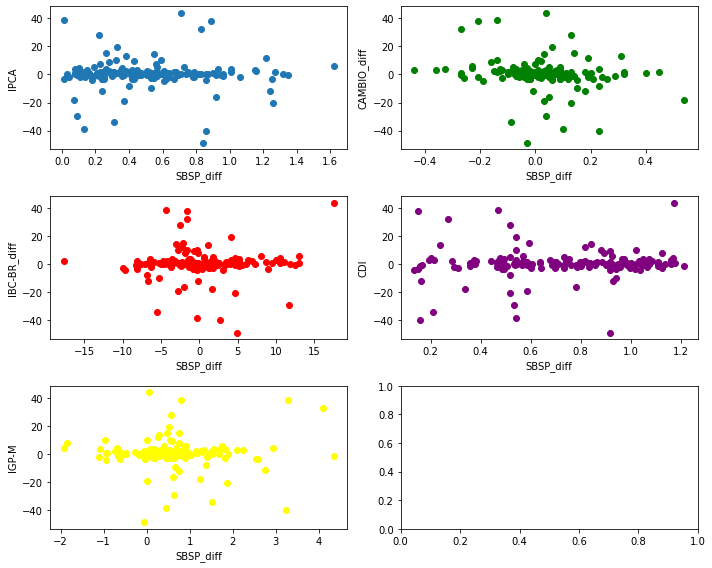

In [63]:
import matplotlib.pyplot as plt

# Create subplots
fig, axes = plt.subplots(3, 2, figsize=(10, 8))

# Scatter plot 1
axes[0, 0].scatter( df['IPCA'], df['SBSP_diff'])
axes[0, 0].set_xlabel('SBSP_diff')
axes[0, 0].set_ylabel('IPCA')

# Scatter plot 2
axes[0, 1].scatter( df['CAMBIO_diff'], df['SBSP_diff'], color='green')
axes[0, 1].set_xlabel('SBSP_diff')
axes[0, 1].set_ylabel('CAMBIO_diff')

# Scatter plot 3
axes[1, 0].scatter(df['IBC-BR_diff'] , df['SBSP_diff'], color='red')
axes[1, 0].set_xlabel('SBSP_diff')
axes[1, 0].set_ylabel('IBC-BR_diff')

# Scatter plot 4
axes[1, 1].scatter( df['CDI'], df['SBSP_diff'], color='purple')
axes[1, 1].set_xlabel('SBSP_diff')
axes[1, 1].set_ylabel('CDI')

# Scatter plot 3
axes[2, 0].scatter(df['IGP-M'] , df['SBSP_diff'], color='yellow')
axes[2, 0].set_xlabel('SBSP_diff')
axes[2, 0].set_ylabel('IGP-M')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

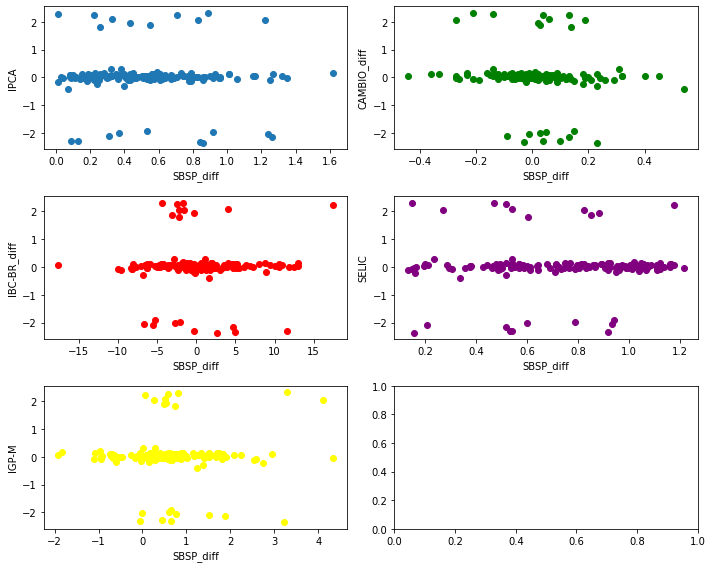

In [61]:
# Create subplots
fig, axes = plt.subplots(3, 2, figsize=(10, 8))

# Scatter plot 1
axes[0, 0].scatter( df['IPCA'], df['LN_DIFF_SBSP'])
axes[0, 0].set_xlabel('SBSP_diff')
axes[0, 0].set_ylabel('IPCA')

# Scatter plot 2
axes[0, 1].scatter( df['CAMBIO_diff'], df['LN_DIFF_SBSP'], color='green')
axes[0, 1].set_xlabel('SBSP_diff')
axes[0, 1].set_ylabel('CAMBIO_diff')

# Scatter plot 3
axes[1, 0].scatter(df['IBC-BR_diff'] , df['LN_DIFF_SBSP'], color='red')
axes[1, 0].set_xlabel('SBSP_diff')
axes[1, 0].set_ylabel('IBC-BR_diff')

# Scatter plot 4
axes[1, 1].scatter( df['SELIC'], df['LN_DIFF_SBSP'], color='purple')
axes[1, 1].set_xlabel('SBSP_diff')
axes[1, 1].set_ylabel('SELIC')

# Scatter plot 3
axes[2, 0].scatter(df['IGP-M'] , df['LN_DIFF_SBSP'], color='yellow')
axes[2, 0].set_xlabel('SBSP_diff')
axes[2, 0].set_ylabel('IGP-M')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

A série da Sabespe logaritmizada e diferenciada possui visualmente uma relação linear melhor com todas as variáveis do que ela apenas diferenciada.

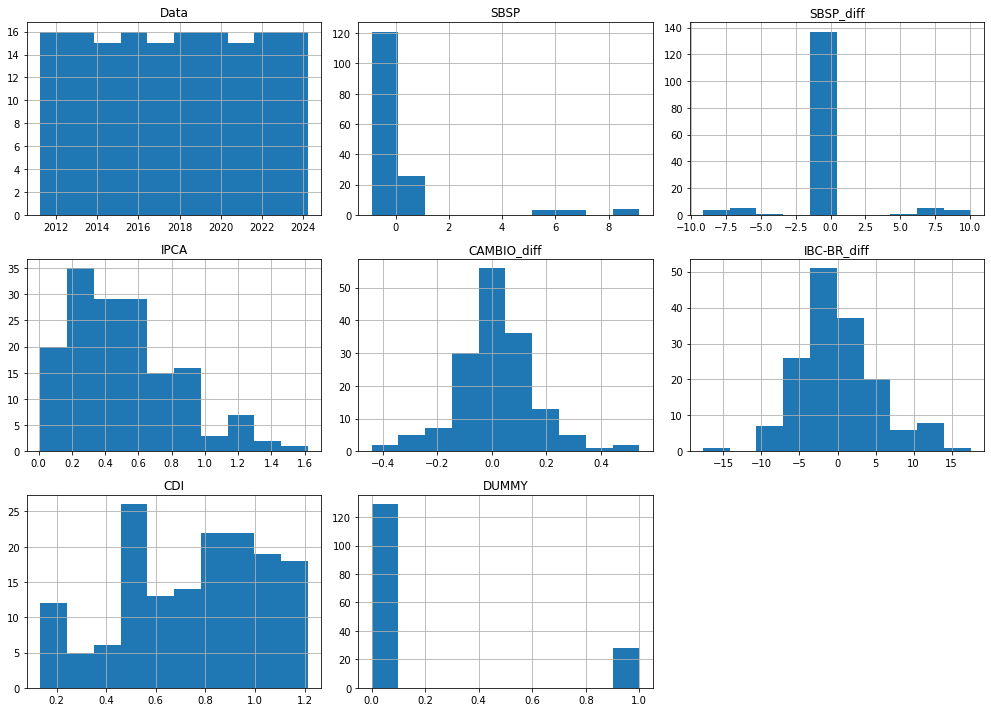

In [40]:
#histogram of the variables
df.hist(figsize=(14, 10))
plt.tight_layout()
plt.show()


<Axes: >

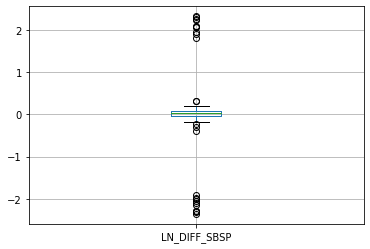

In [174]:
df.boxplot(column=['LN_DIFF_SBSP'])
#SBSP_diff possui muitos outliers

In [65]:
import statsmodels.api as sm

# Define the independent variables
X = df[['IPCA', 'CAMBIO_diff', 'IBC-BR_diff', 'SELIC', 'IGP-M', 'DUMMY']]

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Define the dependent variable
y = df['SBSP']

# Fit the multiple regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   SBSP   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     4.786
Date:                Mon, 10 Jun 2024   Prob (F-statistic):           0.000170
Time:                        13:44:37   Log-Likelihood:                -659.57
No. Observations:                 158   AIC:                             1333.
Df Residuals:                     151   BIC:                             1355.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          36.4667      4.943      7.377      

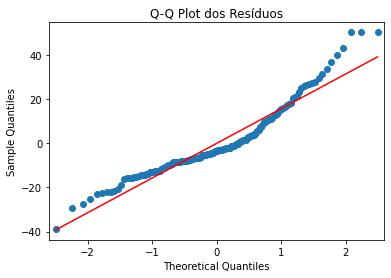

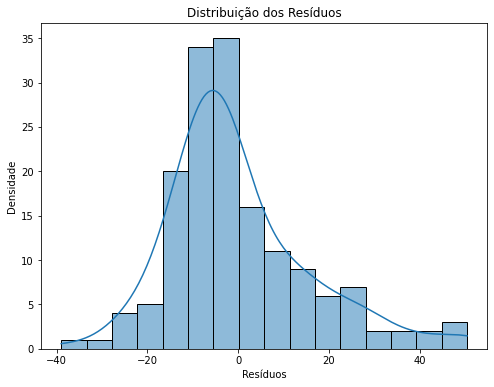

In [66]:
import statsmodels.api as sm# Get the residuals

from statsmodels.graphics.gofplots import qqplot
residuals = model.resid
#qq plot indica se os resíduos são normais quanto mais próximo da linha diagonal
qqplot(residuals, line='s') 
plt.title('Q-Q Plot dos Resíduos')
plt.show()

#histograma para poder visualizar a normalidade melhor
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribuição dos Resíduos')
plt.xlabel('Resíduos')
plt.ylabel('Densidade')
plt.show()

In [67]:
def backward_stepwise_selection(X, y, significance_level=0.10, protected_var='DUMMY'):
    initial_features = X.columns.tolist()
    if protected_var and protected_var in initial_features:
        initial_features.remove(protected_var)
    
    while len(initial_features) > 0:
        model = sm.OLS(y, X[[protected_var] + initial_features]).fit()
        p_values = model.pvalues.loc[initial_features]  # Ignorar a constante e a variável protegida
        max_p_value = p_values.max()
        if max_p_value > significance_level:
            excluded_feature = p_values.idxmax()
            initial_features.remove(excluded_feature)
            print(f'Removed feature: {excluded_feature}, p-value: {max_p_value}')
        else:
            break
    return model

In [69]:
# Define the independent variables
X = df[['IPCA', 'CAMBIO_diff', 'IBC-BR_diff',  'SELIC', 'IGP-M','DUMMY']]

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Define the dependent variable
y = df['SBSP_diff']

# Executar a seleção de variáveis
final_model = backward_stepwise_selection(X, y)

# Imprimir o sumário final
print(final_model.summary())

Removed feature: const, p-value: 0.9993274379076692
Removed feature: IBC-BR_diff, p-value: 0.8795220131200129
Removed feature: IGP-M, p-value: 0.7303610583507953
Removed feature: IPCA, p-value: 0.750302108278261
Removed feature: SELIC, p-value: 0.3060840120377157
                                 OLS Regression Results                                
Dep. Variable:              SBSP_diff   R-squared (uncentered):                   0.034
Model:                            OLS   Adj. R-squared (uncentered):              0.021
Method:                 Least Squares   F-statistic:                              2.732
Date:                Mon, 10 Jun 2024   Prob (F-statistic):                      0.0682
Time:                        13:50:47   Log-Likelihood:                         -596.94
No. Observations:                 158   AIC:                                      1198.
Df Residuals:                     156   BIC:                                      1204.
Df Model:                       

De cara é perceptível que os valores de coeficiente são bem baixos e ja podemos descartar de cara o CDI e IBC-BR_diff por terem p-valor muito alto. Do resto, o único que possui p-valor bem significativo é o CAMBIO_diff.
- O teste de Omnibus com prob(Omnibus) = 0.001 indica que os resíduos não são normalmente distribuidos.
- O teste de Durbin-Watson indica pouca ou nenhuma autocorrelação pois temos um valor 2.192, ou seja, muito próximo de 2.
- O teste de Jarque-Bera indica a normalidade dos resíduos e nesse caso indica que os resíduos não são normalmente distribuidos.
- O Cond.no indica que valores >30 podem indicar problemas de multicolinearidade.

O principal problema a ser tradado no nosso caso é a multicolinearidade. Apesar dos resultados indicarem um possível problema de normalidade dos resíduos, o plot dos resíduos identifica alguns outliers mas um formato agradável.

Para isso, vamos eliminar as variáveis exogenas CDI e IBC-BR_diff que apresentaram não ser significativas e analisar se existe mudança significativa nos resultados.

## Tratamento de outliers

In [76]:
import pandas as pd
#drop the first column of df
df = df.drop(columns=['Data'])
def remove_outliers(df, lower_quantile=0.05, upper_quantile=0.95):
    """
    Remove outliers de um DataFrame utilizando quantis.

    :param df: DataFrame de entrada.
    :param lower_quantile: Limite inferior dos quantis (default: 0.05).
    :param upper_quantile: Limite superior dos quantis (default: 0.95).
    :return: DataFrame sem outliers.
    """
    # Calcula os quantis inferior e superior para cada coluna
    quantiles = df.quantile([lower_quantile, upper_quantile])
    
    # Inicializa uma máscara booleana para todos os valores serem verdadeiros
    mask = pd.Series([True] * len(df))
    
    for col in df.columns:
        # Gera uma máscara para cada coluna, considerando os quantis
        col_mask = (df[col] >= quantiles.loc[lower_quantile, col]) & (df[col] <= quantiles.loc[upper_quantile, col])
        # Combina as máscaras
        mask &= col_mask
    
    # Retorna o DataFrame sem os outliers
    return df[mask]

# Exemplo de uso
# df = pd.read_csv('seu_arquivo.csv')  # Carregar seu DataFrame aqui
# df_sem_outliers = remove_outliers(df)

df_sem_outliers = remove_outliers(df)
df_sem_outliers


,SBSP,LN_SBSP,LN_DIFF_SBSP,SBSP_diff,IPCA,CAMBIO_diff,IBC-BR_diff,CDI,SELIC,IGP-M,DUMMY
0,9.928898,2.295449,-0.000739,-0.007340,0.80,0.00,3.52,0.842429,0.843905,1.00,0
1,11.446117,2.437651,0.142201,1.517219,0.79,-0.01,8.75,0.918851,0.920465,0.62,0
2,11.978629,2.483124,0.045474,0.532512,0.77,-0.07,-5.04,0.838800,0.840161,0.45,0
3,11.762765,2.464939,-0.018185,-0.215864,0.47,0.02,3.34,0.985266,0.987988,0.43,0
4,11.319479,2.426525,-0.038414,-0.443286,0.15,-0.02,-1.48,0.952666,0.956276,-0.18,0
...,...,...,...,...,...,...,...,...,...,...,...
136,41.353739,3.722163,-0.073634,-3.159942,0.67,0.09,-0.87,1.015323,1.011594,0.59,1
142,55.578900,4.017804,-0.053312,-3.043429,0.62,-0.03,1.22,1.123316,1.123316,0.45,0
143,54.123917,3.991276,-0.026527,-1.454983,0.53,-0.04,-6.23,1.123316,1.123316,0.21,0
149,58.100000,4.062166,0.026687,1.530000,0.12,-0.05,4.72,1.071983,1.071983,-0.72,0


## ESSE É O MELHOR RESULTADO PARA A SABESP 
Com o tratamento de outliers
R^2 ajustado: 0.247

In [92]:
import statsmodels.api as sm

# Define the independent variables
X = df_sem_outliers[[ 'CAMBIO_diff', 'SELIC', 'IGP-M', 'DUMMY']]
#X = df_sem_outliers[[ 'CAMBIO_diff',  'DUMMY', 'IBC-BR_diff']]
# Add a constant column to the independent variables
X = sm.add_constant(X)

# Define the dependent variable
y = df_sem_outliers['LN_DIFF_SBSP']

# Fit the multiple regression model
model = sm.OLS(y, X)
results = model.fit()

# Print the summary of the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           LN_DIFF_SBSP   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     7.812
Date:                Tue, 11 Jun 2024   Prob (F-statistic):           2.34e-05
Time:                        09:08:32   Log-Likelihood:                 102.74
No. Observations:                  84   AIC:                            -195.5
Df Residuals:                      79   BIC:                            -183.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0907      0.031      2.943      

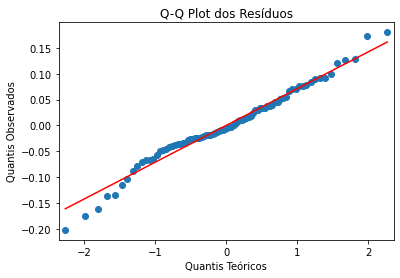

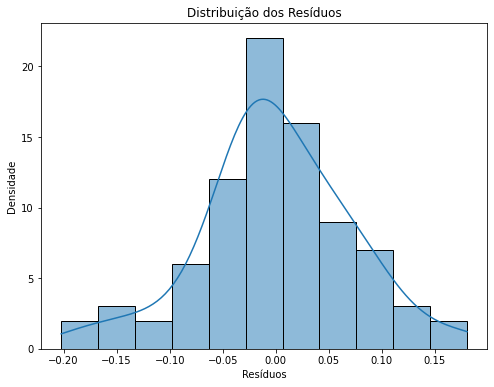

In [93]:
from statsmodels.graphics.gofplots import qqplot
residuals = results.resid
#qq plot indica se os resíduos são normais quanto mais próximo da linha diagonal
qqplot(residuals, line='s') 
plt.title('Q-Q Plot dos Resíduos')
plt.xlabel('Quantis Teóricos')
plt.ylabel('Quantis Observados')
plt.show()

#histograma para poder visualizar a normalidade melhor
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribuição dos Resíduos')
plt.xlabel('Resíduos')
plt.ylabel('Densidade')
plt.show()

In [95]:
# Calculate VIF for each feature

from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)

       feature        VIF
0        const  14.804163
1  CAMBIO_diff   1.121305
2        SELIC   1.088094
3        IGP-M   1.020922
4        DUMMY   1.037607


In [90]:
import statsmodels.api as sm

# Define the independent variables
X = df_sem_outliers[[ 'CAMBIO_diff', 'SELIC', 'DUMMY']]
#X = df_sem_outliers[[ 'CAMBIO_diff',  'DUMMY', 'IBC-BR_diff']]
# Add a constant column to the independent variables
X = sm.add_constant(X)

# Define the dependent variable
y = df_sem_outliers['LN_DIFF_SBSP']

# Fit the multiple regression model
model = sm.OLS(y, X)
results = model.fit()

# Print the summary of the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           LN_DIFF_SBSP   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     9.957
Date:                Tue, 11 Jun 2024   Prob (F-statistic):           1.19e-05
Time:                        09:05:51   Log-Likelihood:                 102.06
No. Observations:                  84   AIC:                            -196.1
Df Residuals:                      80   BIC:                            -186.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0821      0.030      2.745      

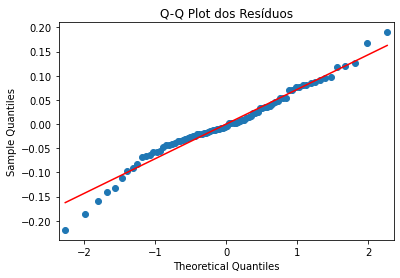

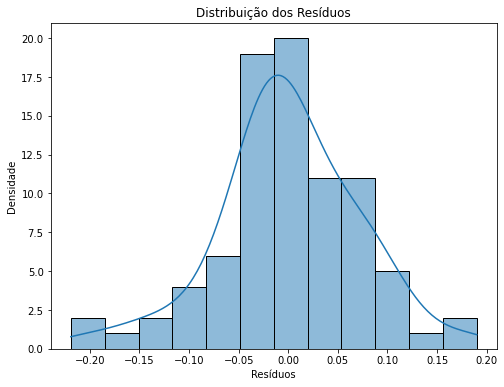

In [91]:
from statsmodels.graphics.gofplots import qqplot
residuals = results.resid
#qq plot indica se os resíduos são normais quanto mais próximo da linha diagonal
qqplot(residuals, line='s') 
plt.title('Q-Q Plot dos Resíduos')
plt.show()

#histograma para poder visualizar a normalidade melhor
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribuição dos Resíduos')
plt.xlabel('Resíduos')
plt.ylabel('Densidade')
plt.show()

Análise::


Pelo PACF:
- SBSP = 3 defasagens
- IPCA: 2 defasagens
- CAMBIO: 2 defasagens
- IBC-BR: 4 defasagens
- CDI: 3 defasagens (???? vontade de morrer)

In [87]:
SBSP3LAG = df['SBSP_diff'].shift(3)
IPCA2LAG = df['IPCA'].shift(2)
CAMBIO2LAG = df['CAMBIO_diff'].shift(2)
IBCBR4LAG = df['IBC-BR_diff'].shift(4)
CDI3LAG = df['SELIC'].shift(2)
IGPM2LAG = df['IGP-M'].shift(2)


data = pd.DataFrame({'SBSP3LAG': SBSP3LAG,
                    'CDI3LAG': CDI3LAG,
                    'IBCBR4LAG':IBCBR4LAG,
                    'IPCA2LAG': IPCA2LAG,
                    'CAMBIO2LAG' : CAMBIO2LAG,
                    'IGPM2LAG': IGPM2LAG,
                    'DUMMY': df['DUMMY']
                    })
data = data.dropna()


In [88]:
y = data['SBSP3LAG']
X = data[['CAMBIO2LAG','DUMMY' ,'IGPM2LAG','CDI3LAG' , 'IPCA2LAG' ]] 
#X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:               SBSP3LAG   R-squared (uncentered):                   0.067
Model:                            OLS   Adj. R-squared (uncentered):              0.036
Method:                 Least Squares   F-statistic:                              2.153
Date:                Mon, 10 Jun 2024   Prob (F-statistic):                      0.0623
Time:                        14:04:46   Log-Likelihood:                         -581.03
No. Observations:                 154   AIC:                                      1172.
Df Residuals:                     149   BIC:                                      1187.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

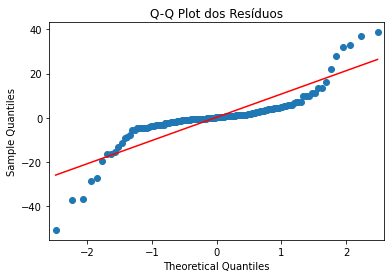

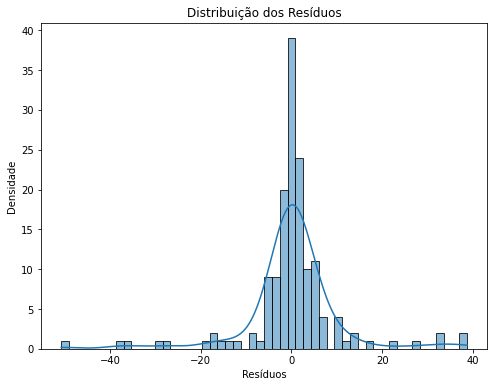

In [89]:
residuals = results.resid
qqplot(residuals, line='s') 
plt.title('Q-Q Plot dos Resíduos')
plt.show()

#histograma para poder visualizar a normalidade melhor
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribuição dos Resíduos')
plt.xlabel('Resíduos')
plt.ylabel('Densidade')
plt.show()

In [182]:
#modelo autoregrssivo
#MODELO AUTOREGRESSIVO
AUTOREG_vol = AutoReg(y, lags=1, exog=X, trend="n")

result_AR_vol = AUTOREG_vol.fit()
result_AR_vol.summary()

c:\Users\carri\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:               SBSP3LAG   No. Observations:                  154
Model:                   AutoReg-X(1)   Log Likelihood                -156.553
Method:               Conditional MLE   S.D. of innovations              0.673
Date:                Thu, 06 Jun 2024   AIC                            323.106
Time:                        12:23:48   BIC                            338.258
Sample:                             1   HQIC                           329.261
                                  154                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
SBSP3LAG.L1    -0.4957      0.071     -7.011      0.000      -0.634      -0.357
CAMBIO2LAG      0.0937      0.377      0.248      0.804      -0.645       0.833
DUMMY          -0.0363      0.147     -0.247      0.805      -0.324       0.252
IPCA2LAG        0.0354      0.104      0.340      0.734      -0.169       0.240
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.0175           +0.0000j            2.0175            0.5000
-----------------------------------------------------------------------------
"""

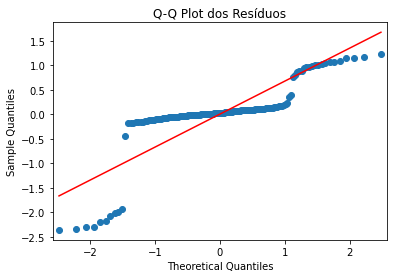

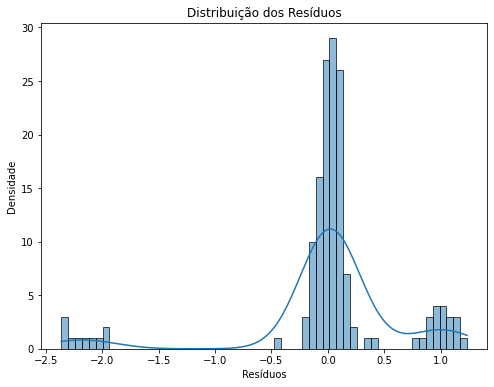

In [183]:
from statsmodels.graphics.gofplots import qqplot

result_AR_vol = result_AR_vol.resid

#qq plot indica se os resíduos são normais quanto mais próximo da linha diagonal
qqplot(result_AR_vol, line='s') 
plt.title('Q-Q Plot dos Resíduos')
plt.show()

#histograma para poder visualizar a normalidade melhor
plt.figure(figsize=(8, 6))
sns.histplot(result_AR_vol, kde=True)
plt.title('Distribuição dos Resíduos')
plt.xlabel('Resíduos')
plt.ylabel('Densidade')
plt.show()